## Initial Setup

In [1]:
!git clone https://github.com/syncdoth/Eagle-Eye-Pneumonia-Detection.git

Cloning into 'Eagle-Eye-Pneumonia-Detection'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 267 (delta 53), reused 60 (delta 28), pack-reused 175
Receiving objects: 100% (267/267), 200.20 KiB | 18.20 MiB/s, done.
Resolving deltas: 100% (130/130), done.


In [1]:
%cd Eagle-Eye-Pneumonia-Detection

/content/Eagle-Eye-Pneumonia-Detection


In [10]:
!pip install --upgrade pip
!pip install -r colab_requirements.txt

     |████████████████████████████████| 206 kB 23.7 MB/s 
     |████████████████████████████████| 63 kB 2.7 MB/s 
     |████████████████████████████████| 961 kB 16.7 MB/s 
     |████████████████████████████████| 3.2 MB 64.9 MB/s 


In [2]:
!git checkout sftp  # only to use sftp

Already on 'sftp'
Your branch is up to date with 'origin/sftp'.


## Train

In [3]:
import torch
from importlib import reload
from torch.utils.data import SubsetRandomSampler
from models.type_classifier import TypeClassifier
import models.train
reload(models.train)
from models.train import train, make_batch
import dataloader.ClassificationDataset
reload(dataloader.ClassificationDataset)
from dataloader.ClassificationDataset import ClassificationDataset, AddGaussianNoise
import torchvision
from torchvision import transforms


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
feature_aug = torchvision.transforms.Compose([
                transforms.ToTensor(),
                transforms.ColorJitter(brightness=[0.1,0.5], contrast=0, saturation=0, hue=0),
                transforms.RandomAffine(degrees=(0,15),
                                        translate=None,
                                        scale=None,
                                        shear=None,
                                        fillcolor=None,
                                        resample=None),
                AddGaussianNoise(0., 1.)])

In [12]:
dataset = ClassificationDataset(root="/home/server/duhyeuk", neg_prop=0.5, trans=None)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, collate_fn=make_batch, sampler=SubsetRandomSampler(dataset.train_idx))
val_loader = torch.utils.data.DataLoader(dataset, batch_size=64, collate_fn=make_batch, sampler=SubsetRandomSampler(dataset.val_idx))
test_loader = torch.utils.data.DataLoader(dataset, batch_size=64, collate_fn=make_batch, sampler=SubsetRandomSampler(dataset.test_idx))

In [ ]:
version = "b1"
pretrain_model = TypeClassifier(version=version, num_classes=4).to(device)

optimizer = torch.optim.Adam(pretrain_model.parameters(), lr=1e-5)
loss = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor(dataset.get_class_weights()).to(device))
epochs = 10

history = train(pretrain_model, optimizer, train_loader, device, loss, 
                val_dataset=val_loader, epochs=epochs,
                model_dir=f"/content/drive/MyDrive/eagle_eye_models/{version}-new")

Loaded pretrained weights for efficientnet-b1


## Visualize Results

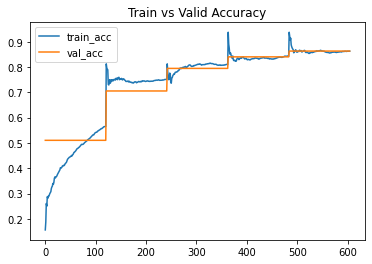

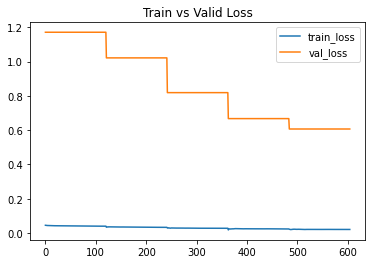

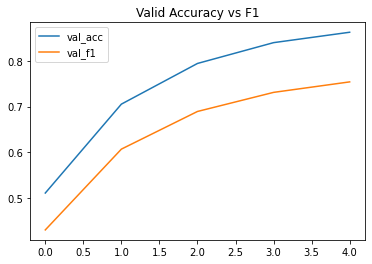

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.title("Train vs Valid Accuracy")
plt.plot(history["train_acc"], label="train_acc")
plt.plot(np.repeat(np.array(history["val_acc"]), len(train_loader)), label="val_acc")
plt.legend()

plt.figure()
plt.title("Train vs Valid Loss")
plt.plot(history["train_loss"], label="train_loss")
plt.plot(np.repeat(np.array(history["val_loss"]), len(train_loader)), label="val_loss")
plt.legend()

plt.figure()
plt.title("Valid Accuracy vs F1")
plt.plot(np.array(history["val_acc"]), label="val_acc")
plt.plot(np.array(history["val_f1"]), label="val_f1")
plt.legend();
